## Identifying CRISPR-Cas9 target-sites unique to heart

This is the Jupyter notebook for comparing two queries sent to GT-Scan2's API, to find target-sites that are active in one tissue but inactive in the other. 

Our usecase here is to stimulate the growth of neutrophils, which are a type of immunecells, specifically in the heart by editing PRAMEF12, a gene that positively regulates cell proliferation. We therefore identify the CRISPR-Cas9 target sites for PRAMEF12 that are active in the heart (E083) but are inactive in primary neutrophils from peripheral blood (E030) from the human genome GRCh37.

### Getting started 

We start by importing the libraries for receiving the data and analyzing and plotting the results further on.

In [2]:
import datetime
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import random
import requests
import seaborn as sns

from pandas.io.json import json_normalize

import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Submitting to GT-Scan2 API

We submit two 'POST' requests to GT-Scan2's API using the exact same genomic regions (the PRAMEF12 gene).

In [3]:
base_url = 'https://jqhp2vtj5k.execute-api.ap-southeast-2.amazonaws.com/prod'

submit_url = '{}/submit'.format(base_url)

#For analysing neutrophils tissue data
blood_data = '''{
  "genome": "GRCh37",
  "chromosome": "1",
  "proximal": 12775442,
  "distal": 12776218,
  "cellLine": "E030"
}'''
blood_post_response = requests.post(submit_url, data=blood_data)

#For analysing heart tissue data
heart_data = '''{
  "genome": "GRCh37",
  "chromosome": "1",
  "proximal": 12775442,
  "distal": 12776218,
  "cellLine": "E083"
}'''
heart_post_response = requests.post(submit_url, data=heart_data)

#12775442

In [4]:
print("Evaluated genomic space", 12776218-12775442, "bp")

Evaluated genomic space 776 bp


### Confirming Job Submission

GT-Scan2's returns a JobID that can be used retrieve the analysis results

In [5]:
blood_job = blood_post_response.json()
blood_id = blood_job['JobID']
blood_id

'gt7065469'

In [6]:
heart_job = heart_post_response.json()
heart_id = heart_job['JobID']
heart_id

'gt8075834'

### Retrieving results

We use the 'GET' function to obtain the results.

Note: GT-Scan2 is a distributed system so results are subdivided and processed in parallele. The system hence releases the results as they become available, which means that in order to retrieve the full result the 'GET' function may need to be executed several times until all is retrieved (43 out of 43 targets are complete) or executed once after a waiting period of a couple of minutes. 

In [25]:
blood_url = '{}/results/{}/targets'.format(base_url, blood_id)
blood_targets_response = requests.get(blood_url)
blood_x = blood_targets_response.json()

activities = [i['activity'] != '' for i in blood_x['data']]
print('{} out of {} targets are complete.'.format(sum(activities), len(activities)))

158 out of 158 targets are complete.


In [26]:
heart_url = '{}/results/{}/targets'.format(base_url, heart_id)
heart_targets_response = requests.get(heart_url)
heart_x = heart_targets_response.json()

activities = [i['activity'] != '' for i in heart_x['data']]
print('{} out of {} targets are complete.'.format(sum(activities), len(activities)))

158 out of 158 targets are complete.


###Analyzing the data

We first load the data into a pandas dataframe and removing result entries that are not relevant for this analysis

In [27]:
blood_result = pd.DataFrame(json_normalize(blood_targets_response.json(), 'data'))
blood_result.head()

,activity,gc,histones,location,ot_one,ot_three,ot_two,ot_zero,position,sequence,strand,transcription,tuscan
0,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775446,0,32,3,0,4,GGAAAAACCAAGCAGTGGGGGGG,+,0,1.720964
1,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775453,0,17,2,0,11,TTGCTCACCCCCCCACTGCTTGG,-,0,1.835650
2,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775455,0,58,3,0,13,AAGCAGTGGGGGGGTGAGCAAGG,+,0,2.182512
3,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775458,0,64,0,0,16,CAGTGGGGGGGTGAGCAAGGTGG,+,0,3.013404
4,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775459,0,35,2,0,17,AGTGGGGGGGTGAGCAAGGTGGG,+,0,1.963300


In [28]:
heart_result = pd.DataFrame(json_normalize(heart_targets_response.json(), 'data'))
heart_result.head()

,activity,gc,histones,location,ot_one,ot_three,ot_two,ot_zero,position,sequence,strand,transcription,tuscan
0,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775446,0,32,3,0,4,GGAAAAACCAAGCAGTGGGGGGG,+,0,1.720964
1,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775453,0,17,2,0,11,TTGCTCACCCCCCCACTGCTTGG,-,0,1.835650
2,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775455,0,58,3,0,13,AAGCAGTGGGGGGGTGAGCAAGG,+,0,2.182512
3,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775458,0,64,0,0,16,CAGTGGGGGGGTGAGCAAGGTGG,+,0,3.013404
4,High,8.695652,"[{'name': 'h3k14ac', 'present': None}, {'name'...",12775459,0,35,2,0,17,AGTGGGGGGGTGAGCAAGGTGGG,+,0,1.963300


Droping unwanted columns

In [29]:
blood_result.drop(['histones', 'gc', 'position', 'transcription','ot_zero','ot_one','ot_two','ot_three'], axis = 1, inplace = True)
heart_result.drop(['histones', 'gc', 'position', 'transcription','ot_zero','ot_one','ot_two','ot_three'], axis = 1, inplace = True)

Renaming and reordering columns

In [30]:
blood_result.columns = ['activity', 'location', 'sequence', 'strand','score']
heart_result.columns = ['activity', 'location', 'sequence', 'strand','score']

In [31]:
blood_df = blood_result[['location', 'strand', 'sequence', 'activity','score']]
heart_df = heart_result[['location', 'strand', 'sequence', 'activity','score']]

Note: If you find out the data are incompleted (e.g. activity missing), please go back previous steps to reload the output from GT-Scan2 through API to variables neutrophils_response and heart_response.

In [32]:
blood_df.head()

,location,strand,sequence,activity,score
0,12775446,+,GGAAAAACCAAGCAGTGGGGGGG,High,1.720964
1,12775453,-,TTGCTCACCCCCCCACTGCTTGG,High,1.835650
2,12775455,+,AAGCAGTGGGGGGGTGAGCAAGG,High,2.182512
3,12775458,+,CAGTGGGGGGGTGAGCAAGGTGG,High,3.013404
4,12775459,+,AGTGGGGGGGTGAGCAAGGTGGG,High,1.963300


In [33]:
heart_df.head()

,location,strand,sequence,activity,score
0,12775446,+,GGAAAAACCAAGCAGTGGGGGGG,High,1.720964
1,12775453,-,TTGCTCACCCCCCCACTGCTTGG,High,1.835650
2,12775455,+,AAGCAGTGGGGGGGTGAGCAAGG,High,2.182512
3,12775458,+,CAGTGGGGGGGTGAGCAAGGTGG,High,3.013404
4,12775459,+,AGTGGGGGGGTGAGCAAGGTGGG,High,1.963300


### Visualizing the results

Like GT-Scan2 we plot the genomic location along with all possible target sites evaluated by their activity.

In [34]:
# Simulation to create random data with numpy, it's actually not real random data

random_0 = random.randint(1, 100)
random_1 = random.randint(1, 100)
random_2 = random.randint(1, 100)
random_3 = random.randint(1, 100)

blood_random_x = blood_df['location'].loc[(blood_df['strand'] == '+') & (blood_df['activity'] == 'Low')]
blood_random_x1 = blood_df['location'].loc[(blood_df['strand'] == '-') & (blood_df['activity'] == 'Low')]
blood_random_x2 = blood_df['location'].loc[(blood_df['strand'] == '+') & (blood_df['activity'] == 'High')]
blood_random_x3 = blood_df['location'].loc[(blood_df['strand'] == '-') & (blood_df['activity'] == 'High')]

blood_random_y0 = blood_df['location'].loc[(blood_df['strand'] == '+') & (blood_df['activity'] == 'Low')]*random_0%100+1
blood_random_y1 = blood_df['location'].loc[(blood_df['strand'] == '-') & (blood_df['activity'] == 'Low')]*random_1%100+1
blood_random_y2 = blood_df['location'].loc[(blood_df['strand'] == '+') & (blood_df['activity'] == 'High')]*random_2%100+1
blood_random_y3 = blood_df['location'].loc[(blood_df['strand'] == '-') & (blood_df['activity'] == 'High')]*random_3%100+1

heart_random_x = heart_df['location'].loc[(heart_df['strand'] == '+') & (heart_df['activity'] == 'Low')]
heart_random_x1 = heart_df['location'].loc[(heart_df['strand'] == '-') & (heart_df['activity'] == 'Low')]
heart_random_x2 = heart_df['location'].loc[(heart_df['strand'] == '+') & (heart_df['activity'] == 'High')]
heart_random_x3 = heart_df['location'].loc[(heart_df['strand'] == '-') & (heart_df['activity'] == 'High')]

heart_random_y0 = heart_df['location'].loc[(heart_df['strand'] == '+') & (heart_df['activity'] == 'Low')]*random_0%100+1
heart_random_y1 = heart_df['location'].loc[(heart_df['strand'] == '-') & (heart_df['activity'] == 'Low')]*random_1%100+1
heart_random_y2 = heart_df['location'].loc[(heart_df['strand'] == '+') & (heart_df['activity'] == 'High')]*random_2%100+1
heart_random_y3 = heart_df['location'].loc[(heart_df['strand'] == '-') & (heart_df['activity'] == 'High')]*random_3%100+1

# Create traces
blood_trace0 = go.Scatter(
    x = blood_random_x,
    y = blood_random_y0,
    mode = 'markers',
    name = '+ Low',
    marker = dict(
        size = 10,
        symbol='triangle-right',
        color='black'
        )
)
blood_trace1 = go.Scatter(
    x = blood_random_x1,
    y = blood_random_y1,
    mode = 'markers',
    name = '- Low',
     marker = dict(
        size = 10,
        symbol='triangle-left',
        color='black'
        )
)

blood_trace2 = go.Scatter(
    x = blood_random_x2,
    y = blood_random_y2,
    mode = 'markers',
    name = '+ High',
     marker = dict(
        size = 10,
        symbol='triangle-right', 
        color='green'
        )
)
blood_trace3 = go.Scatter(
    x = blood_random_x3,
    y = blood_random_y3,
    mode = 'markers',
    name = '- High',
     marker = dict(
        size = 10,
        symbol='triangle-left',
         color='green'
        )
)

heart_trace0 = go.Scatter(
    x = heart_random_x,
    y = heart_random_y0,
    mode = 'markers',
    name = '+ Low',
    marker = dict(
        size = 10,
        symbol='triangle-right',
        color='black'
        )
)
heart_trace1 = go.Scatter(
    x = heart_random_x1,
    y = heart_random_y1,
    mode = 'markers',
    name = '- Low',
     marker = dict(
        size = 10,
        symbol='triangle-left',
        color='black'
        )
)

heart_trace2 = go.Scatter(
    x = heart_random_x2,
    y = heart_random_y2,
    mode = 'markers',
    name = '+ High',
     marker = dict(
        size = 10,
        symbol='triangle-right', 
        color='green'
        )
)
heart_trace3 = go.Scatter(
    x = heart_random_x3,
    y = heart_random_y3,
    mode = 'markers',
    name = '- High',
     marker = dict(
        size = 10,
        symbol='triangle-left',
         color='green'
        )
)

In [35]:
blood_data = [blood_trace0, blood_trace1, blood_trace2, blood_trace3]
py.iplot(blood_data, filename='cas9-target-sites-view-scatter-mode-1')

In [36]:
heart_data = [heart_trace0, heart_trace1, heart_trace2, heart_trace3]
py.iplot(heart_data, filename='cas9-target-sites-view-scatter-mode-2')

## Identifying the target site active in heart but not blood

First we join the dataframes and filter for the sites that are active in heart 'High' but inactive in blood 'Low'.

In [37]:
joined = pd.merge(blood_df, heart_df, on=['location','strand','sequence'], suffixes=('_blood', '_heart'))
joined['delta']=np.where(joined['activity_blood'] == joined['activity_heart'],'same', joined['activity_heart'])
joined.head()

,location,strand,sequence,activity_blood,score_blood,activity_heart,score_heart,delta
0,12775446,+,GGAAAAACCAAGCAGTGGGGGGG,High,1.720964,High,1.720964,same
1,12775453,-,TTGCTCACCCCCCCACTGCTTGG,High,1.835650,High,1.835650,same
2,12775455,+,AAGCAGTGGGGGGGTGAGCAAGG,High,2.182512,High,2.182512,same
3,12775458,+,CAGTGGGGGGGTGAGCAAGGTGG,High,3.013404,High,3.013404,same
4,12775459,+,AGTGGGGGGGTGAGCAAGGTGGG,High,1.963300,High,1.963300,same


In [38]:
joined[joined['delta'].str.contains("High")]

,location,strand,sequence,activity_blood,score_blood,activity_heart,score_heart,delta
85,12775775,+,CTGATGGATGGATGATAAGCTGG,Low,1.204805,High,1.204805,High
116,12775988,-,GAGGATGTGGTTCTAGGACAGGG,Low,1.155527,High,1.155527,High
134,12776045,+,GTTTGTGGGACCCAGGGAGGTGG,Low,1.181184,High,1.181184,High
148,12776122,-,GTGCGCAGTGGAAACCATTTAGG,Low,1.142778,High,1.142778,High
157,12776188,-,CTGCGAGGAAGATCAGGGCCAGG,Low,1.159563,High,1.159563,High


In [39]:
joined['label'] = joined["delta"].map(str) + joined["strand"] # join strand and activity for color label

# create the marker array for the plot
joined['m'] = joined.apply(lambda x: '<' if x['label'][-1]=='+' else '>', axis=1)
marker=joined[['label','m']].drop_duplicates()['m'].values.tolist()
marker

['<', '>', '<', '<', '>']

In [40]:
# create the color array for the plot
joined['c'] = 'greyish'
joined.loc[joined['delta']=='High', 'c'] = 'amber'
joined.loc[joined['delta']=='Low', 'c'] = 'black'
color=joined[['label','c']].drop_duplicates()['c'].values.tolist()
color


['greyish', 'greyish', 'black', 'amber', 'amber']

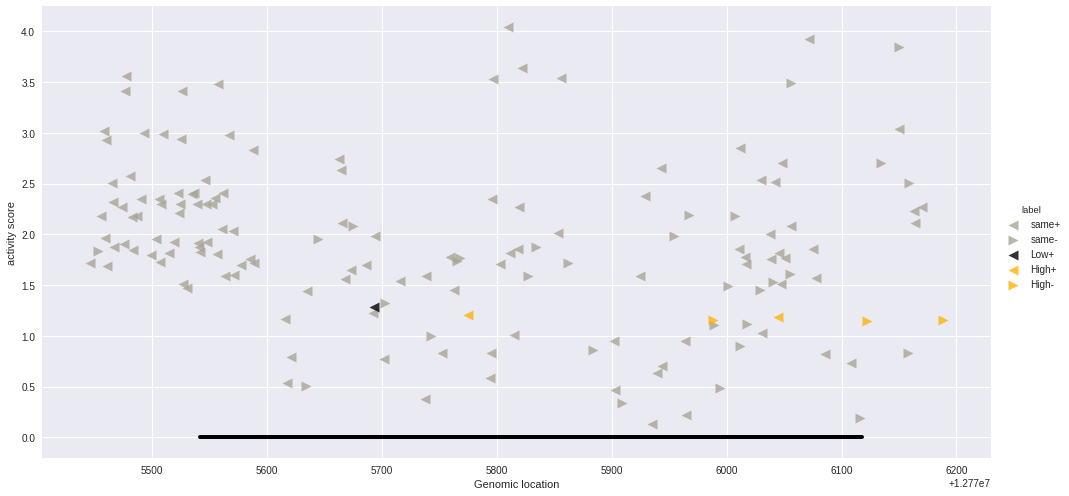

In [41]:
g= sns.lmplot('location', # Horizontal axis
           'score_heart', # Vertical axis
           data=joined, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="label", # Set color
           palette=sns.xkcd_palette(color), # set color palette
           markers = marker, # set marker 
              scatter_kws={"s": 100}, #size of the markers
             size=7, aspect=2) #size of the image

g.set(xlabel='Genomic location', ylabel='activity score')

import matplotlib.pyplot as plt
#plt.plot([12774840,12775154], [0,0], linewidth=4, c='black') #first exon
plt.plot([12775542,12776118], [0,0], linewidth=4, c='black') #second exon
#plt.plot([12777010,12777906], [0,0], linewidth=4, c='black') #third exon
